In [9]:
import sys
import os
sys.path.append('../')

In [10]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
from optimizers import IPS, AdaIPS_S
from utils.getData import getData

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 10)
        
        self.t_losses = []
        self.v_losses = []
        

    def forward(self, x):
        x = x.view(-1, 28*28).float()
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [12]:
epochs = 10
batch_size = 64


In [13]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainloader, trainset, testloader, testset, validationloader, valset = getData('MNIST', transform=transform, batch_size=batch_size)

In [14]:
def train(model, optimizer, epochs=2):
    model.train()
    print(optimizer)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer

    num_epochs = epochs
    for epoch in range(num_epochs):
        running_loss = 0
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            def closure():
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                return loss

    
            # if i % 100 == 0:                
            #     with torch.no_grad():
            #         for v_i, (v_inputs, v_labels) in enumerate(validationloader):
            #             v_inputs, v_labels = v_inputs.to(device), v_labels.to(device)
            #             v_outputs = model(v_inputs)
            #             v_loss = criterion(v_outputs, v_labels)
                    
            #         print("validation loss", v_loss.item())                   
            #     model.v_losses.append(v_loss.item())
                
            loss = optimizer.step(closure)
            running_loss += loss
            
            if i % 100 == 0:
                print(f'Epoch {epoch+1}, Step {i}, Loss: {loss}')
                model.t_losses.append(loss.item())
        
        # model.t_losses.append(running_loss / len(trainloader.dataset))
            

    print("Training complete.")
    return model

In [15]:
def test(model, per_class=False):
    model.eval()
    for i, (inputs, labels) in enumerate(testloader):
        with torch.no_grad():
            output = model(inputs)
            output = output.argmax(axis=1)
        
        print("predicted classes:", np.unique(output.detach().numpy()))
        precision, recall, fscore, _ = precision_recall_fscore_support(labels, output.detach().numpy(), average='weighted')
        print(f"accuracy: {accuracy_score(labels, output.detach().numpy())}")
        

        print(f"precision: {precision}\nrecall: {recall}\nfscore: {fscore}")
        if not per_class: 
            return
        
        for i in range(10):
            print(f"Class {i} -> Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1-score: {fscore[i]:.4f}")


In [16]:
adaIpsModel = SimpleNN().to(device)
adaIpsOptimizer = AdaIPS_S(adaIpsModel.parameters())
train(adaIpsModel, adaIpsOptimizer, epochs=epochs)

initialized optimizer with per layer learning rate: False, no T
AdaIPS_S (
Parameter Group 0
    beta_1: 0.9
    beta_2: 0.999
    eps: 1e-08
    lower_bound: 0
)
Epoch 1, Step 0, Loss: 2.3107662200927734
Epoch 1, Step 100, Loss: 0.6932327747344971
Epoch 1, Step 200, Loss: 0.25743889808654785
Epoch 1, Step 300, Loss: 0.30443131923675537
Epoch 1, Step 400, Loss: 0.35254237055778503
Epoch 1, Step 500, Loss: 0.19598062336444855
Epoch 1, Step 600, Loss: 0.14488868415355682
Epoch 1, Step 700, Loss: 0.07854975014925003
Epoch 2, Step 0, Loss: 0.19220882654190063
Epoch 2, Step 100, Loss: 0.15229329466819763
Epoch 2, Step 200, Loss: 0.12096749246120453
Epoch 2, Step 300, Loss: 0.08603546023368835
Epoch 2, Step 400, Loss: 0.21913109719753265
Epoch 2, Step 500, Loss: 0.037517596036195755
Epoch 2, Step 600, Loss: 0.09174277633428574
Epoch 2, Step 700, Loss: 0.08017327636480331
Epoch 3, Step 0, Loss: 0.09727514535188675
Epoch 3, Step 100, Loss: 0.01547415554523468
Epoch 3, Step 200, Loss: 0.0723761

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [17]:
ipsModel = SimpleNN().to(device)
ipsOptimizer = IPS(ipsModel.parameters(), T=epochs * (len(trainset) / batch_size), lower_bound=0)
train(ipsModel, ipsOptimizer, epochs=epochs)

IPS (
Parameter Group 0
    T: 7500.0
    lower_bound: 0
)
Epoch 1, Step 0, Loss: 2.2829785346984863
Epoch 1, Step 100, Loss: 0.8841853737831116
Epoch 1, Step 200, Loss: 0.6012282371520996
Epoch 1, Step 300, Loss: 0.5317307710647583
Epoch 1, Step 400, Loss: 0.7920453548431396
Epoch 1, Step 500, Loss: 0.49680835008621216
Epoch 1, Step 600, Loss: 0.44800087809562683
Epoch 1, Step 700, Loss: 0.4536612033843994
Epoch 2, Step 0, Loss: 0.40121620893478394
Epoch 2, Step 100, Loss: 0.5751181840896606
Epoch 2, Step 200, Loss: 0.37324169278144836
Epoch 2, Step 300, Loss: 0.20219577848911285
Epoch 2, Step 400, Loss: 0.5197176337242126
Epoch 2, Step 500, Loss: 0.3616069555282593
Epoch 2, Step 600, Loss: 0.3273221254348755
Epoch 2, Step 700, Loss: 0.43114733695983887
Epoch 3, Step 0, Loss: 0.41243159770965576
Epoch 3, Step 100, Loss: 0.2289869338274002
Epoch 3, Step 200, Loss: 0.3932468891143799
Epoch 3, Step 300, Loss: 0.26617082953453064
Epoch 3, Step 400, Loss: 0.43307891488075256
Epoch 3, Step 

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [18]:
adamModel = SimpleNN().to(device)
adamOptimizer = torch.optim.Adam(adamModel.parameters(), lr=1e-3)
train(adamModel, adamOptimizer, epochs=epochs)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Epoch 1, Step 0, Loss: 2.3023757934570312
Epoch 1, Step 100, Loss: 0.5198431015014648
Epoch 1, Step 200, Loss: 0.4937017261981964
Epoch 1, Step 300, Loss: 0.2540059983730316
Epoch 1, Step 400, Loss: 0.2450692504644394
Epoch 1, Step 500, Loss: 0.22075608372688293
Epoch 1, Step 600, Loss: 0.27315688133239746
Epoch 1, Step 700, Loss: 0.10267690569162369
Epoch 2, Step 0, Loss: 0.11717268079519272
Epoch 2, Step 100, Loss: 0.09799366444349289
Epoch 2, Step 200, Loss: 0.14024917781352997
Epoch 2, Step 300, Loss: 0.07062767446041107
Epoch 2, Step 400, Loss: 0.11417564004659653
Epoch 2, Step 500, Loss: 0.15663820505142212
Epoch 2, Step 600, Loss: 0.06548057496547699
Epoch 2, Step 700, Loss: 0.08911310136318207
Epoch 3, Step 0, Loss: 0.07727592438459396
Epoch 3, Step 100, Loss: 

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [19]:
rmsModel = SimpleNN().to(device)
rmsOptimizer = torch.optim.RMSprop(rmsModel.parameters(), lr=1e-3)
train(rmsModel, rmsOptimizer, epochs=epochs)

RMSprop (
Parameter Group 0
    alpha: 0.99
    capturable: False
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0
    weight_decay: 0
)
Epoch 1, Step 0, Loss: 2.3081932067871094
Epoch 1, Step 100, Loss: 0.26891887187957764
Epoch 1, Step 200, Loss: 0.31092002987861633
Epoch 1, Step 300, Loss: 0.45929014682769775
Epoch 1, Step 400, Loss: 0.2315363585948944
Epoch 1, Step 500, Loss: 0.27756524085998535
Epoch 1, Step 600, Loss: 0.3135260343551636
Epoch 1, Step 700, Loss: 0.23155611753463745
Epoch 2, Step 0, Loss: 0.17704015970230103
Epoch 2, Step 100, Loss: 0.0799705982208252
Epoch 2, Step 200, Loss: 0.2072228491306305
Epoch 2, Step 300, Loss: 0.0590069405734539
Epoch 2, Step 400, Loss: 0.20618264377117157
Epoch 2, Step 500, Loss: 0.07396955043077469
Epoch 2, Step 600, Loss: 0.05858834460377693
Epoch 2, Step 700, Loss: 0.0510348416864872
Epoch 3, Step 0, Loss: 0.11151149868965149
Epoch 3, Step 100, Loss: 0.0548

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

[2.3107662200927734, 0.6932327747344971, 0.25743889808654785, 0.30443131923675537, 0.35254237055778503, 0.19598062336444855, 0.14488868415355682, 0.07854975014925003, 0.19220882654190063, 0.15229329466819763, 0.12096749246120453, 0.08603546023368835, 0.21913109719753265, 0.037517596036195755, 0.09174277633428574, 0.08017327636480331, 0.09727514535188675, 0.01547415554523468, 0.07237615436315536, 0.10351119190454483, 0.02402823604643345, 0.057844068855047226, 0.15764252841472626, 0.038526806980371475, 0.07558000087738037, 0.052744071930646896, 0.01597791723906994, 0.06496401131153107, 0.021029217168688774, 0.02453361079096794, 0.0858137309551239, 0.0316631942987442, 0.05668994411826134, 0.13081659376621246, 0.013330820016562939, 0.004214773885905743, 0.09549923986196518, 0.1359129250049591, 0.10366476327180862, 0.028189564123749733, 0.008002850227057934, 0.04739220812916756, 0.032674286514520645, 0.03484872728586197, 0.006380124017596245, 0.01733279600739479, 0.08688250184059143, 0.0095

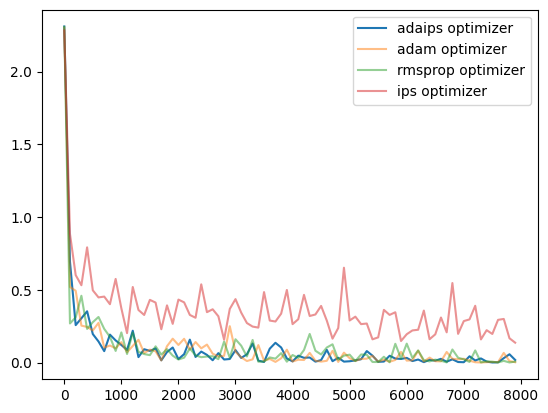

In [20]:

models = [
    (adaIpsModel, 'adaips optimizer'),
    (adamModel, 'adam optimizer'),
    (rmsModel, 'rmsprop optimizer'),
    (ipsModel, 'ips optimizer'),

]
exclude = []
focus = [adaIpsModel]
interval = 1
for model, optimizer in models:
    print(model.t_losses)
    plt.plot(
        [i * 100 for i, loss in enumerate(model.t_losses) if i % interval == 0], 
        [loss for i, loss in enumerate(model.t_losses) if i % interval == 0], 
        label=optimizer,
        alpha=0.5 if model not in focus else 1
    )

plt.legend()
plt.show()

In [21]:
for model, optimizer in models:
    print(optimizer)
    test(model)
    print('-' * 20, end='\n')

adaips optimizer
predicted classes: [0 1 2 3 4 5 6 7 8 9]
accuracy: 0.9754
precision: 0.9755164737099878
recall: 0.9754
fscore: 0.9753979254165323
--------------------
adam optimizer
predicted classes: [0 1 2 3 4 5 6 7 8 9]
accuracy: 0.9746
precision: 0.9747538159492953
recall: 0.9746
fscore: 0.9745989973290958
--------------------
rmsprop optimizer
predicted classes: [0 1 2 3 4 5 6 7 8 9]
accuracy: 0.9748
precision: 0.9748638145028666
recall: 0.9748
fscore: 0.9747755359013208
--------------------
ips optimizer
predicted classes: [0 1 2 3 4 5 6 7 8 9]
accuracy: 0.9255
precision: 0.9258098856690731
recall: 0.9255
fscore: 0.9253826786298553
--------------------


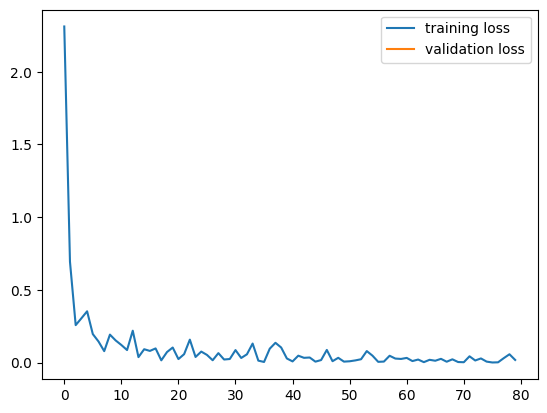

In [22]:

plt.plot([t for t in adaIpsModel.t_losses], label='training loss')
plt.plot([v for v in adaIpsModel.v_losses], label='validation loss')
plt.legend()
plt.show()
